In [1]:
import geopy.distance as dst
import pickle
import matplotlib.pyplot as plt
import math
import numpy as np
import random as r

In [2]:
def calcLength(coords_1, coords_2):
    return dst.geodesic(coords_1, coords_2).m
    
def writeNodes(path:str, nodes):
    line = ""
    for nd, nd_dt in enumerate(nodes):
        line += "\n" + str(nd) + " " + str(nd_dt[0]) + " " + str(nd_dt[1])
    file = open(path, "w+")
    file.write(line)
    file.close()

def writeAdjList(path:str, adj_lst):
    line = ""
    for nd, adj_nodes in enumerate(adj_lst):
        line += "\n" + str(nd)
        for adj_nd in adj_nodes:
            adj_nd_dt = adj_nodes[adj_nd]
            line += " " + str(adj_nd) + " " + str(adj_nd_dt[0]) + " " + str(adj_nd_dt[1])
    file = open(path, "w+")
    file.write(line)
    file.close()

def getDataNodes(ntx, path_nodes:str, path_adj_list:str):
    id2indx = {}
    n = len(ntx.nodes.data(True))
    nodes = []
    adj_lst = []
    for i, ntx_nd in enumerate(ntx.nodes.data(True)):
        id2indx[ntx_nd[0]] = i
        nodes.append((ntx_nd[1]['y'], ntx_nd[1]['x']))
        adj_lst.append({})
    for nd_id in ntx:
        nd = id2indx[nd_id]
        for adj_id in ntx[nd_id]:
            adj_nd = id2indx[adj_id]
            lngth = calcLength(nodes[nd], nodes[adj_nd])
            adj_lst[nd][adj_nd] = [lngth, r.randint(0, 100) / 100]
    writeNodes(path_nodes, nodes)
    writeAdjList(path_adj_list, adj_lst)

def only_path(root, end, path):
    if path[end] == -1:return []
    n_path = [end]
    while n_path[-1] != root:
        n_path.append(path[n_path[-1]])
    return list(reversed(n_path))

0.43952

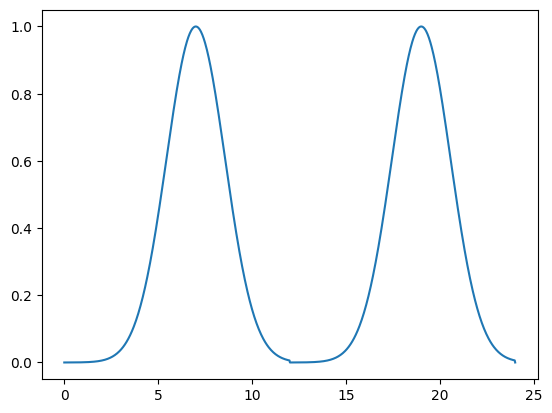

In [3]:
def getCoefTrafic(hora):
    trafic_o = 0.6
    trafic_base = math.e/(math.sqrt(2 * math.pi) * trafic_o)
    hora = hora % 12
    coef = -0.5 * ((hora - 7.)/ trafic_o / 2 )**2
    value = trafic_base ** coef
    return value
hour = 18
coef = getCoefTrafic(hour)


fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 24, 1000)
y = [getCoefTrafic(i) for i in x]
ax.plot(x, y)
round(getCoefTrafic(5), 5)


In [4]:
class Graph:
    nodes = [] #lista de informacion de nodos nodes[0] informacion del nodo 0
    adj_lst = [] #lista de listas de adjacencias adj_lst[0][1] informacion de la arista 0->1
    size = 0
    def __init__(self, path_nodes:str, path_adj_list:str):
        if len(path_nodes) > 2 and len(path_adj_list) > 2:
            file = open(path_nodes, 'r')
            next(file)
            for line in file:
                words = line.split()
                self.nodes.append((float(words[1]), float(words[2])))
                self.adj_lst.append({})
            file.close()
            file = open(path_adj_list, 'r')
            next(file)
            for line in file:
                words = line.split()
                nd = int(words[0])
                for adj_nd in range(1, len(words), 3):
                    self.adj_lst[nd][int(words[adj_nd])] = ((float(words[adj_nd + 1]), float(words[adj_nd + 2])))
            file.close()
            self.n = len(self.nodes)

    def __getitem__(self, node):
        return self.nodes[node] if node in range(len(self.nodes)) else (0,0)

    def edge(self, nd, adj_nd):
        return self.adj_lst[nd][adj_nd]

    def generateHeuristic(self, end):
        end_data = self.nodes[end]
        return [calcLength(nd_dt, end_data) for nd_dt in self.nodes]

    def getWayByTime(self, root, end, hour = 7, v = 25):
        path, g, trfc = self.aStarTime(root, end, hour, v)
        print(g[end])
        return g[end], list(only_path(root, end, path)), trfc


    def normalizePositions(self, pi, pf):
        if pf[0] < pi[0]:
            pi[0], pf[0] = pf[0], pi[0]
        if pf[1] < pi[1]:
            pi[1], pf[1] = pf[1], pi[1]

    def getAreaNodes(self, pi, pf, nodes = None):
        area_nodes = []
        if nodes is None:
            nodes = range(len(self.nodes))
        self.normalizePositions(pi, pf)
        for nd in nodes:
            nd_data = self.nodes[nd]
            if nd_data[0] < pi[0] or nd_data[0] > pf[0] or nd_data[1] < pi[1] or nd_data[1] > pf[1]:
                continue
            area_nodes.append(nd)
        return area_nodes

    def plotf(self, axes):
        for nd, adj_nodes in enumerate(self.adj_lst):
            nd_data = self.nodes[nd]
            for adj_nd in adj_nodes:
                adj_data = self.nodes[adj_nd]
                axes.plot([nd_data[1], adj_data[1]], [nd_data[0],adj_data[0]], linewidth = 0.7, markersize = 0.5, color = 'b')

    def getTrafficColor(self, trfc):
        if trfc > 1.9:
            c = 'red'
        elif trfc > 1.7:
            c = 'orange'
        elif trfc > 1.25:
            c = 'yellow'
        else:
            c = 'c'
        return c
        
    def plotfPath(self, axes, path, traffic = False, root = False, end = False):
        plot_count = 0
        n = len(path)
        visited = [False] * n
        if root and end:
            if not (path[end] == -1 or root == end):
                nd = end
                while nd != root:
                    nd_data = self.nodes[nd]
                    prev_data = self.nodes[path[nd]]
                    if traffic:
                        c = self.getTrafficColor(traffic[nd])
                    else:
                        c = 'r'
                    axes.plot([prev_data[1], nd_data[1]], [prev_data[0], nd_data[0]], linewidth = 2, markersize = 0.5, color = c)
                    visited[nd] = True;
                    nd = path[nd]
                    plot_count += 1

        for nd in range(n):
            if visited[nd] or path[nd] == -1: continue
            nd_data = self.nodes[nd]
            prev_data = self.nodes[path[nd]]
            if traffic:
                c = self.getTrafficColor(traffic[nd])
            else:
                c = 'r'
            axes.plot([prev_data[1], nd_data[1]], [prev_data[0], nd_data[0]], linewidth = 1.0, markersize = 0.5, color = c)
            
            plot_count += 1
        return plot_count

    def plotfWay(self, axes, way, traffic = False):
        n = len(way)
        n_lines = 0
        if n < 2:
            return 0
        for i in range(n - 1):
            nd1_data = self.nodes[way[i]]
            nd2_data = self.nodes[way[i + 1]]
            if traffic:
                c = self.getTrafficColor(traffic[way[i + 1]])
            else:
                c = 'r'
            axes.plot([nd1_data[1], nd2_data[1]], [nd1_data[0], nd2_data[0]], linewidth = 2, markersize = 0.5, color = c)
            n_lines += 1
        return n_lines

    def plotfNode(self, axes, nd):
        axes.plot(self.nodes[nd][1], self.nodes[nd][0], marker="o", markersize=5, markeredgecolor="red")

    def getNearestNodes(self, pos, n):
        a_nodes = self.getAreaNodes([pos[0] - n, pos[1] - n], [pos[0] + n, pos[1] + n])
        if len(a_nodes) == 0: return []
        while True:
            n /= 2
            b_nodes = self.getAreaNodes([pos[0] - n, pos[1] - n], [pos[0] + n, pos[1] + n], a_nodes)
            new_len = len(b_nodes)
            if new_len > 10:
                a_nodes = b_nodes
            elif new_len > 0:
                return b_nodes
            else:
                return a_nodes

    def getNearestNode(self, pos, n = 0.00001):
        nearest_nodes = self.getNearestNodes(pos, n)
        if len(nearest_nodes) == 0: return None
        nrst_nd = -1
        min = math.inf
        for nd in nearest_nodes:
            dist = calcLength(self.nodes[nd], pos)
            if dist < min:
                nrst_nd = nd
                min = dist
        return nrst_nd

    def save(self, path_nodes, path_adj_list):
        writeNodes(path_nodes, self.nodes)
        writeAdjList(path_adj_list, self.adj_lst)

    def getCoefTrafic(hora):
        trafic_o = 0.6 #dispersion
        trafic_base = math.e/(math.sqrt(2 * math.pi) * trafic_o)
        hora = hora % 12
        coef = -0.5 * ((hora - 7.)/ trafic_o / 2 )**2
        value = trafic_base ** coef
        return value

    def getTimeHeuristics(self, end):
        end_data = self.nodes[end]
        return [calcLength(nd_dt, end_data) for nd_dt in self.nodes]
        
    def aStarTime(self, root, end, hour = 7, v = 25):
        path = [-1] * self.n
        g = [math.inf] * self.n
        h = self.generateHeuristic(end)
        f = [math.inf] * self.n
        hour_trfc = getCoefTrafic(hour)
        traffic = [{}] * self.n
        g[root] = 0
        test_nds = set()
        def assignLabels(nd):
            for adj in self.adj_lst[nd]:
                nd_trfc = traffic[nd]
                if nd_trfc.get(adj) is None: nd_trfc[adj] = round(1 + self.adj_lst[nd][adj][1] * hour_trfc, 4)
                _g = g[nd] + self.adj_lst[nd][adj][0] * nd_trfc[adj]
                if g[adj] > _g:
                    path[adj] = nd
                    g[adj] = _g
                    f[adj] = _g + h[adj]
                    if adj not in test_nds: test_nds.add(adj)
        def getNextNode(nd):
            min = math.inf
            id = -1
            for tst_nd in test_nds:
                if f[tst_nd] < min:
                    min = f[tst_nd]
                    id = tst_nd
            return id

        tmp_nd = root
        test_nds.add(tmp_nd)
        while not(tmp_nd == end or tmp_nd == -1):
            test_nds.remove(tmp_nd)
            assignLabels(tmp_nd)
            tmp_nd = getNextNode(tmp_nd)
        trfc = [None] * self.n
        for nd in range(self.n):
            if path[nd] != -1:
                trfc[nd] = traffic[path[nd]][nd]
        print(g[root], g[end])
        return path, g, trfc

In [5]:
B = Graph("nodes.txt","edges.txt")

In [6]:
from tkinter import *
from tkinter import ttk
from time import sleep

from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
import numpy as np

root = Tk()
root.wm_title("MyGPS")

distancia = StringVar()
position = StringVar()
position.set('position')

#plt.style.use('fivethirtyeight')
fig = Figure(figsize=(7, 7), dpi=100)
map_canvas = FigureCanvasTkAgg(fig, master=root)
axes = fig.add_subplot(111)
axes.set_axis_off()
B.plotf(axes)
map_canvas.draw()

#print(fig.axes[0].get_lines())
toolbar = NavigationToolbar2Tk(map_canvas, root)
toolbar.update()
map_canvas.get_tk_widget().pack(side=TOP, fill=BOTH, expand=1)
#map_canvas.draw()

canvas2= Canvas(root, width=100, height=100)

nodes = [-1, -1]
contador = 0
n_lines = 0

#EVENT FUNCTION
def motion(event):
    x, y = event.x, event.y
    position.set(str(x) + ", " + str(y))

def on_key_press(event):
    print("you pressed {}".format(event.key))
    key_press_handler(event, map_canvas, toolbar)

def removePlot(axes, n_lines):
    for _ in range(n_lines + 2):
        line = axes.get_lines().pop()
        line.remove()

def on_button_press(event):
    global contador
    global n_lines
    x = event.xdata
    y = event.ydata
    if contador < 2 and contador > -1:
        selected_node = B.getNearestNode([y, x], 0.001)
        if not selected_node is None:
            nodes[contador] = selected_node
            B.plotfNode(fig.axes[0], nodes[contador])
            contador += 1
            if contador == 2:
                removePlot(fig.axes[0], 2)
                #path, length, trfc = B.aStarTime(nodes[0], nodes[1], 5)
                #n_lines = B.plotfPath(fig.axes[0], path, trfc, nodes[0], nodes[1])
                length, way, trf = B.getWayByTime(nodes[0], nodes[1], 7)
                n_lines = B.plotfWay(fig.axes[0], way, trf)
                B.plotfNode(fig.axes[0], nodes[0])
                B.plotfNode(fig.axes[0], nodes[1])
                distancia.set(str(round(length)) + " m")
            map_canvas.draw()
    else:
        removePlot(fig.axes[0], n_lines)
        map_canvas.draw()
        contador = 0

def key(event):
    print("pressed", repr(event.char))

def callback(event):
    print("clicked at", event.x, event.y)

    
#FUNCTION
def _quit():
    root.quit()     # stops mainloop
    root.destroy()  # this is necessary on Windows to prevent

#EVENTS
map_canvas.mpl_connect("key_press_event", on_key_press)
map_canvas.mpl_connect("button_press_event", on_button_press)
canvas2.bind("<Key>", key)
canvas2.bind("<Button-1>", callback)
root.bind('<Motion>', motion)


button = Button(master=root, text="Quit", command=_quit)
label_lngth = Label(master=root, textvariable=distancia)
button.pack(side=BOTTOM)
label_lngth.pack(side=BOTTOM)
#canvas2.pack()

mainloop()

0 4354.958746645621
4354.958746645621
you pressed win
you pressed shift
you pressed  
0 10368.311078865016
10368.311078865016
you pressed win
you pressed shift
you pressed  
0 9511.14127996906
9511.14127996906
you pressed  
you pressed  
0 20645.397866206917
20645.397866206917
you pressed win
you pressed shift
